## Creating dataset and splitting it

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# 1. Define the Custom Dataset
class CustomerDataset(Dataset):
    def __init__(self, num_samples=2000):
        # Simulate 20 input features (Age, Salary, Debt, etc.)
        self.features = torch.randn(num_samples, 20)
        
        # Target 1: Churn (Binary: 0 or 1)
        self.churn_labels = torch.randint(0, 2, (num_samples, 1)).float()
        
        # Target 2: Future Credit Score (Continuous: 300 to 850)
        self.credit_labels = torch.randn(num_samples, 1) * 100 + 650

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx]
        y_churn = self.churn_labels[idx]
        y_credit = self.credit_labels[idx]
        return x, y_churn, y_credit

# 2. Create DataLoaders
dataset = CustomerDataset()
# Split into Train and Test (80/20)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

print(f"Batch Shape: {next(iter(train_loader))[0].shape}") 

Batch Shape: torch.Size([1600, 20])


In [20]:
train_features, train_churn_labels, train_credit_labels = next(iter(train_loader))
test_features, test_churn_labels, test_credit_labels = next(iter(test_loader))

In [21]:
train_features.shape, train_churn_labels.shape, train_credit_labels.shape, test_features.shape, test_churn_labels.shape, test_credit_labels.shape

(torch.Size([1600, 20]),
 torch.Size([1600, 1]),
 torch.Size([1600, 1]),
 torch.Size([400, 20]),
 torch.Size([400, 1]),
 torch.Size([400, 1]))

## Regression Task

### Model Building

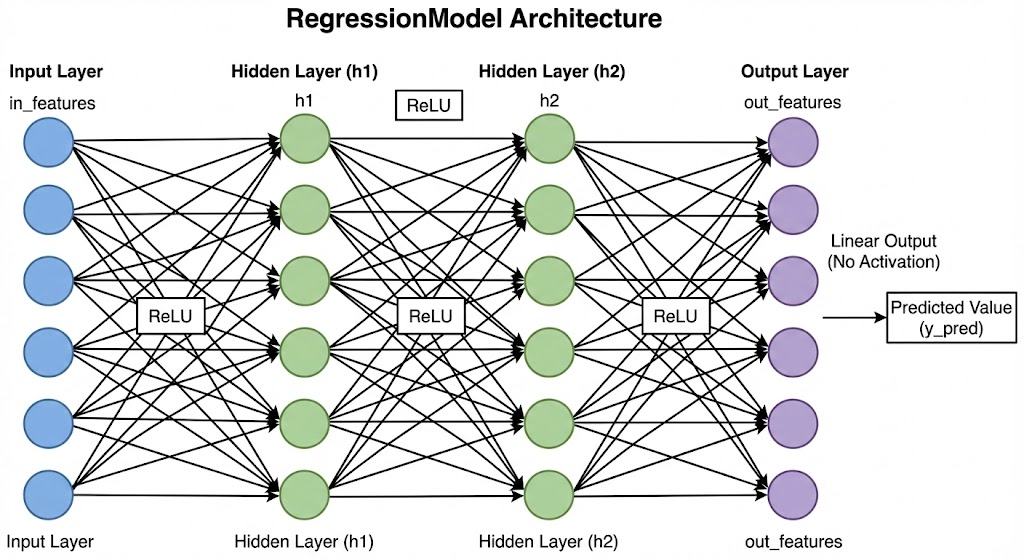

In [22]:
class RegressionModel(nn.Module):
    def __init__(self, in_features, h1, h2, out_features):
        super().__init__()
        self.input_layer = nn.Linear(in_features=in_features, out_features=h1)
        self.hidden_layer1 = nn.Linear(in_features=h1, out_features=h2)
        self.output_layer = nn.Linear(in_features=h2, out_features=out_features)
    
    def forward(self, x):
        x = self.input_layer(x)
        x = torch.relu(x)
        x = self.hidden_layer1(x)
        x = torch.relu(x)
        x = self.output_layer(x)
        return x

In [23]:
regress_model = RegressionModel(in_features=train_features.shape[-1], h1=12, h2=6, out_features=1)
optimizer = optim.SGD(params=regress_model.parameters(), lr = 0.01)
criterion = nn.MSELoss()

In [29]:
regress_model.state_dict()

OrderedDict([('input_layer.weight',
              tensor([[-0.0605, -0.1284, -0.0405,  0.1936, -0.1344,  0.1487, -0.0596,  0.1673,
                       -0.1156,  0.0182, -0.0146,  0.1760, -0.0602,  0.2226, -0.0574,  0.0411,
                        0.1079, -0.0903,  0.1991,  0.2206],
                      [-0.1561, -0.1708,  0.1968, -0.1236,  0.1321,  0.0614,  0.0565,  0.2016,
                        0.0551, -0.0154, -0.1094, -0.1473, -0.1698, -0.0748,  0.2081,  0.0861,
                        0.0886, -0.1145,  0.0641,  0.2119],
                      [-0.1826,  0.0556, -0.1614,  0.0801, -0.2135,  0.1667, -0.1119,  0.1656,
                        0.0352,  0.1324, -0.0991, -0.1552, -0.0626, -0.1743,  0.1979,  0.2104,
                       -0.1626,  0.1617,  0.1301,  0.0082],
                      [ 0.0898, -0.2011, -0.0346, -0.1831,  0.1629,  0.1043,  0.1260,  0.1641,
                       -0.0235,  0.1789,  0.0829, -0.1396,  0.1133, -0.0449,  0.1568,  0.0506,
                       -

### Model training

In [ ]:
regress_model.forward
criterion()

In [31]:
def train_regress_model(model, X_train, y_train, X_test, y_test, optimizer, criterion, n_epochs=100):
    history_train_loss = []
    history_test_loss = []
    
    for epoch in range(n_epochs):
        # 1. Set to Training Mode 
        model.train()

        # 2. Forward Pass 
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        # 3. Optimization Steps
        optimizer.zero_grad() # Clear previous gradients
        loss.backward()       # Calculate new gradients
        optimizer.step()      # Update weights

        history_train_loss.append(loss.item())

        # 4. Evaluation Loop
        model.eval() # Set to Evaluation Mode 
        with torch.inference_mode():
            test_y_pred = model(X_test)
            test_loss = criterion(test_y_pred, y_test)
            history_test_loss.append(test_loss.item())
            
    return history_train_loss, history_test_loss

In [32]:
history_train_loss, history_test_loss = train_regress_model(regress_model, train_features, train_churn_labels, test_features, test_churn_labels, optimizer, criterion, )

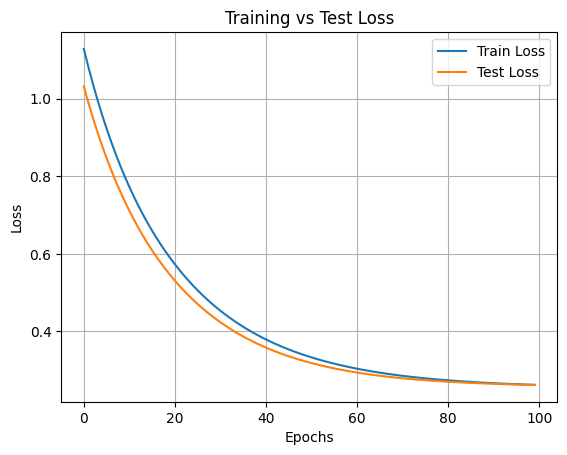

In [36]:
import matplotlib.pyplot as plt

plt.plot(history_train_loss, label='Train Loss')
plt.plot(history_test_loss, label='Test Loss')

plt.title("Training vs Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)

plt.legend() 

plt.show()